<a href="https://colab.research.google.com/github/Satwikram/Deep-Learning-Implementations/blob/master/Image%20%2B%20Text/Image%20%2B%20Text%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

### Connecting to kaggle

In [1]:
from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Downloading the Dataset

In [2]:
!kaggle datasets download -d fushenggg/3-class-cat-dog-car-dataset

 97% 120M/123M [00:02<00:00, 59.2MB/s] 
100% 123M/123M [00:03<00:00, 42.9MB/s]


In [3]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 127MB/s]


In [ ]:
!unzip /content/3-class-cat-dog-car-dataset.zip
!unzip /content/news-headlines-dataset-for-sarcasm-detection.zip

### Importing Dependencies

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import string
import re

import os
from pathlib import Path

import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split


from tqdm import tqdm

### Loading the data

In [7]:
df = pd.read_json("/content/Sarcasm_Headlines_Dataset.json", lines=True)
df.drop(columns="article_link", axis=1, inplace = True)

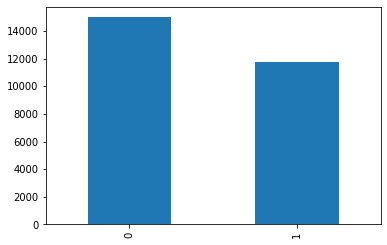

In [8]:
df["is_sarcastic"].value_counts().plot(kind="bar");